# 「プチ」勉強会 20230715
* 先週の続き。応用の「レビューのスコアを予想しよう」を自然言語処理用専用ライブラリを使わずにEDAで解決する試み。
* EDAの深堀と精緻化、大量データに負けないコードの実行時間の短縮化がテーマ。
* 実は、先週比スコアが顕著に伸びたわけではない（若干の改善）。でもコードの実行時間は各段に短くできた。
* スコアに関しては、個々の特徴量は単独ではどれもスコア改善に寄与するが、上限に近いのか限界効用が急速に低減する。
* 試しに訓練データ全体で訓練して敢えてリークしてみたら0.5台だった。リークしてもその程度。
* そういう意味では、先週の着眼点は悪くなかったし、それで終わりでも悪くはなかった。
* でも、今回の深堀はとてもためになったし発見があって面白かった。

## 今回取り組んでみたこと

1. EDAの深堀と特徴量の追加。意味的な探索に止まらず、異なる切り口でスコアに傾向の差があればあらゆる可能性を試す方針で臨んだ。<br>
先週は、ベースラインに対するスコアアップの観点から低評価に焦点を当てた特徴量探索を行ったが、今週は、
```
   ・4と5の区分の明確化が数的にスコアへの影響が無視できないため、高評価の特徴量も抽出
   ・wordの意味的な探索に止まらず、wordをさらに分割したcharacter(letter)ベースでの頻度も追加
   ・ほか、文章の長さに加えてword自体の文字数や、低評価に目立つ数字のカウントも加えた
   ・あと、word_scoreの捉え方に気が付いた。そして、どのスコアでも頻度に差のない単語を省く処理を行うことで特徴量の意味を明確化できた。
```
2. 引き続き、データ量の多さに対応するため、より少ないデータで、より速いコーディングで実施できるよう工夫した
```
   ・有意な特徴量を増やしたことで、個別wordは各スコア別高頻度4000語で十分になった。（3000語でもそん色ないスコアになる）
   　（個別wordの特徴量を増やすとスコアが改善するが、一定レベル以上は改善しないこともわかった）
   ・特徴量の改善と共通するが、一律に文字数で切るのではなく各スコアに頻度差がない中間wordを省いたことも計算時間の短縮化に貢献している。
   ・SVR（サポートベクタマシン）は高性能だがデータが増えると級数的に遅くなることを改めて確認
```
3. その他、可視化も工夫してみた。小技もいくつか覚えた。<br>
現在は仕事もわりと忙しい時期だが、充実感のある週だった。

## レビューのスコアを予測しよう

In [273]:
# 0-1
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
%matplotlib inline

from sklearn.model_selection import train_test_split            # データ分割
from sklearn.metrics import mean_squared_error                  # MSE
import lightgbm as lgb                                          # Light GBM

from collections import defaultdict, Counter                    # collectionsライブラリ
from pprint import pprint
import warnings
warnings.simplefilter('ignore')

sns.set(style='white')
import japanize_matplotlib

In [274]:
# 0-2
# 訓練用データ
df = pd.read_csv('C:\\Users\\yuich\\KC_data\\review_score\\train.csv')
# 提出用データ
df_test = pd.read_csv('C:\\Users\\yuich\\KC_data\\review_score\\test.csv') 

## データ概観

In [275]:
# 1-0
# 訓練データ
display(df.info())
display(df.head())
display(df.describe())
display(df.describe(include='object'))

# 提出用データ
display(df_test.info())
display(df_test.head())
display(df_test.describe())
display(df_test.describe(include='object'))

# 欠損値                     ： train   test
# review_text                :    2       0

# レビューテキストは文字通り文章なのでほとんどunique。
# 2つの欠損、あと108の重複はおそらくはエラー的なもの（#NAME?）と定型のコメントか繰り返しの投稿。
# あとはreview_socore別に単語の頻度調査を行って傾向を見ていく。
# 基本的に4と5が多い（平均4.229）
# 標準偏差0.97なのでそれ以下で予想したい（ベースラインはAll 4）

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118064 entries, 0 to 118063
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         118064 non-null  int64 
 1   review_text   118062 non-null  object
 2   review_score  118064 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ MB


None

,index,review_text,review_score
0,80351,Sunday is relaxing day. But I want to explore ...,2
1,24757,My wife and I visited this restaurant on a qui...,1
2,114219,Came to Shang Palace for dinner and enjoyed th...,5
3,134782,The snacks are very good quality and the take ...,4
4,23792,We didn't know what to expect but were thoroug...,5


,index,review_score
count,118064.000,118064.000
mean,73831.045,4.229
std,42598.961,0.970
min,1.000,1.000
25%,36960.500,4.000
50%,73812.000,4.000
75%,110724.250,5.000
max,147580.000,5.000


,review_text
count,118062
unique,117954
top,#NAME?
freq,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29517 entries, 0 to 29516
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        29517 non-null  int64 
 1   review_text  29517 non-null  object
dtypes: int64(1), object(1)
memory usage: 461.3+ KB


None

,index,review_text
0,50923,Food is good but too much non veg dish creates...
1,48414,We love the buffet here. it is very famous fo...
2,17951,Great place for a chill evening on the weekday...
3,36227,A legendary restaurant of Delhi (and India) th...
4,30281,I had to walk for 2 hours and got lost trying ...


,index
count,29517.000
mean,73625.825
std,42620.025
min,0.000
25%,36669.000
50%,73690.000
75%,110578.000
max,147571.000


,review_text
count,29517
unique,29508
top,#NAME?
freq,5


## EDA（データ探索）

```Dataset.columns

review_score  : レビューのスコア
index         : レビューの固有 ID
review_text   : レビュー内容
```

In [276]:
# 欠損値処理

df = df.drop(index=[47171, 86303])
df.info()

# 欠損値は2つのみNaN表示なので削除するしかない

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118062 entries, 0 to 118063
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         118062 non-null  int64 
 1   review_text   118062 non-null  object
 2   review_score  118062 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [277]:
# 外れ値

# 明らかにネガティブな内容であるに関わらず高評価であったりその逆のものもある
# しかし、量も多く、ひとつひとつ確認することは困難なのでここでは弄らない

In [278]:
# review_textのクリーニング

def clean_text(text):
    text = str(text).lower()                 # 小文字に変換
    text = re.sub(r'[^\s0-9a-z]', '', text)  # 数字と英数字以外を削除
    text = re.sub('\s+', ' ', text).strip()  # 余分なスペースの削除
    return text

df['clean_text'] = df['review_text'].apply(clean_text)

display(df)

# クリーニングの意味は、意味のある単語だけ残して特徴量の品質を高めることにある
# 最低限の処理として、小文字化と記号類の削除を行う（但し、あまり記号類が多い印象はない）
# nltk(自然言語キット)は自然言語処理の基本的なメソッドを提供していてSTOPWORDSも用意されているがここでは使用しない
# 必要に応じて自分で設定していけば精度を上げられる余地があると思う
# ちなみにSTOPWORDでもネガティブなニュアンスの文脈に頻出する傾向があれば特徴量とする意味がある
# 大文字小文字でさえ、そこに特徴量が潜んでいる可能性はある。

,index,review_text,review_score,clean_text
0,80351,Sunday is relaxing day. But I want to explore ...,2,sunday is relaxing day but i want to explore s...
1,24757,My wife and I visited this restaurant on a qui...,1,my wife and i visited this restaurant on a qui...
2,114219,Came to Shang Palace for dinner and enjoyed th...,5,came to shang palace for dinner and enjoyed th...
3,134782,The snacks are very good quality and the take ...,4,the snacks are very good quality and the take ...
4,23792,We didn't know what to expect but were thoroug...,5,we didnt know what to expect but were thorough...
...,...,...,...,...
118059,37678,I have been wanting to visit this cafe for qui...,4,i have been wanting to visit this cafe for qui...
118060,104347,We were four of us and had varied interest in ...,5,we were four of us and had varied interest in ...
118061,95950,We went for our anniversary celebration and si...,4,we went for our anniversary celebration and si...
118062,13824,had an amazing mouth lickering appetizer which...,5,had an amazing mouth lickering appetizer which...


In [279]:
# review_score
df_01 = df[(df['review_score'] == 1)]
df_05 = df[(df['review_score'] == 5)]
display(df_01)
display(df_05)

scores = df['review_score'].value_counts()
print(scores)

# 1が最も評価が低く5が高い。
# 低評価の数は少なく、4と5が大部分なので、いかに低評価のものを見分けるかがポイント。
# ちなみに、数が多いので4と5の区分を見分けることもスコアアップには大事。つまり主な着眼点はその2つ。

,index,review_text,review_score,clean_text
1,24757,My wife and I visited this restaurant on a qui...,1,my wife and i visited this restaurant on a qui...
5,94698,Was pretty excited initially to find a place b...,1,was pretty excited initially to find a place b...
66,72890,Had a friend's bday party. Seems the cook was ...,1,had a friends bday party seems the cook was ha...
67,53542,In a strictly simplistic point of view piano m...,1,in a strictly simplistic point of view piano m...
83,52370,I am listing all things which went wrong durin...,1,i am listing all things which went wrong durin...
...,...,...,...,...
117909,51097,It was below average for all the food which I ...,1,it was below average for all the food which i ...
117935,8680,me and my friend go to this restuarant and eat...,1,me and my friend go to this restuarant and eat...
117938,42178,Our group of 12 people went for lunch. We were...,1,our group of 12 people went for lunch we were ...
117969,132708,We had to wait a good 20- 30 minutes before so...,1,we had to wait a good 20 30 minutes before som...


,index,review_text,review_score,clean_text
2,114219,Came to Shang Palace for dinner and enjoyed th...,5,came to shang palace for dinner and enjoyed th...
4,23792,We didn't know what to expect but were thoroug...,5,we didnt know what to expect but were thorough...
7,128291,This the the best place to have food at a pock...,5,this the the best place to have food at a pock...
8,13908,The whole experience is out of our expectation...,5,the whole experience is out of our expectation...
9,76435,Such a cute place with great ambience and amaz...,5,such a cute place with great ambience and amaz...
...,...,...,...,...
118057,29690,Had lunch twice at the House of Ming during my...,5,had lunch twice at the house of ming during my...
118058,66400,I wa there with a friend from USA and we thoro...,5,i wa there with a friend from usa and we thoro...
118060,104347,We were four of us and had varied interest in ...,5,we were four of us and had varied interest in ...
118062,13824,had an amazing mouth lickering appetizer which...,5,had an amazing mouth lickering appetizer which...


5    57872
4    40127
3    12859
2     3645
1     3559
Name: review_score, dtype: int64


In [280]:
# リーク防止のため最初から分割

df_train, df_val = train_test_split(df, test_size=0.2)

In [281]:
# 特徴量 text_len

df_train['text_len'] = df_train['clean_text'].apply(lambda x: len(x.split()))
df_val['text_len'] = df_val['clean_text'].apply(lambda x: len(x.split()))

display(df_train)

# 単語の数。あとで纏めて視覚化するが、低評価ほど長い傾向。

,index,review_text,review_score,clean_text,text_len
39303,65484,We have been visiting this place for quite som...,3,we have been visiting this place for quite som...,71
101575,98993,Had a great dining experience here. Food was g...,5,had a great dining experience here food was gr...,35
6473,125948,"favorites - mini idli with ghee,dosa are best ...",5,favorites mini idli with gheedosa are best in ...,42
50170,79460,Mediterranean and Italian Items were creative ...,3,mediterranean and italian items were creative ...,27
12335,87152,Recently we were at Select city mall and after...,4,recently we were at select city mall and after...,55
...,...,...,...,...,...
2886,78558,We have tried food from Saravana Bhavan in Dub...,3,we have tried food from saravana bhavan in dub...,66
61493,126495,Food @ Saravana is undoubtedly outstanding - w...,4,food saravana is undoubtedly outstanding we we...,94
82989,65482,Civil house:::::::: Insta: bhukkadbros This w...,5,civil house insta bhukkadbros this was my firs...,69
38872,134163,Thought of trying something different from Dom...,1,thought of trying something different from dom...,43


In [282]:
# 特徴量 diff_len

df_train['diff_len'] = df_train['text_len'] - df_train['clean_text'].apply(lambda x: len(x.split()))
df_val['diff_len'] = df_val['text_len'] - df_val['clean_text'].apply(lambda x: len(x.split()))

display(df_train)

# 全般に特殊文字や記号が少なく、また、STOPWORDSを使っていないのでdiff_lenは少ししかない。
# 一応、着眼点は全て残すが特徴量とするほどでもない。
# STOPWORDSを使うとdiff_lenでも低スコアの比率が若干高いことがわかる。

,index,review_text,review_score,clean_text,text_len,diff_len
39303,65484,We have been visiting this place for quite som...,3,we have been visiting this place for quite som...,71,0
101575,98993,Had a great dining experience here. Food was g...,5,had a great dining experience here food was gr...,35,0
6473,125948,"favorites - mini idli with ghee,dosa are best ...",5,favorites mini idli with gheedosa are best in ...,42,0
50170,79460,Mediterranean and Italian Items were creative ...,3,mediterranean and italian items were creative ...,27,0
12335,87152,Recently we were at Select city mall and after...,4,recently we were at select city mall and after...,55,0
...,...,...,...,...,...,...
2886,78558,We have tried food from Saravana Bhavan in Dub...,3,we have tried food from saravana bhavan in dub...,66,0
61493,126495,Food @ Saravana is undoubtedly outstanding - w...,4,food saravana is undoubtedly outstanding we we...,94,0
82989,65482,Civil house:::::::: Insta: bhukkadbros This w...,5,civil house insta bhukkadbros this was my firs...,69,0
38872,134163,Thought of trying something different from Dom...,1,thought of trying something different from dom...,43,0


In [283]:
# 特徴量 word_len

df_train['word_len'] = df_train['clean_text'].apply(lambda x: len(x) / len(x.split()))
df_val['word_len'] = df_val['clean_text'].apply(lambda x:len(x) / len(x.split()))

# 文章の長さは低評価の特徴量だが、wordの長さは逆に長いほど高評価、という意味で貴重な特徴量。
# なぜそうなるのかは不明。

In [284]:
# 特徴量 digit

df_train['digit'] = df_train['clean_text'].apply(lambda x: len([d for d in x.split() if d.isdigit()]) / len(x.split()))
df_val['digit'] = df_val['clean_text'].apply(lambda x: len([d for d in x.split() if d.isdigit()]) / len(x.split()))

# 数字は明らかに低評価に頻出する傾向。見た目で分かる。

In [285]:
# 特徴量 character_count

# Counterを使ってcharacterの平均出現頻度を抽出する関数
def character_count(text):
    text = re.sub('r[^a-z]', '', text)  # 小文字アルファベット以外は全部消す
    return {'c_' + key: value / len(text) for key, value in Counter(text).items()}

# string.axcii_lowercaceを使ってcharacterの順番を揃える
# その際、先頭に'c_'を付けて、単語としての１文字抽出と重複しないようにする
import string
ordered_col = ['c_'+ i for i in iter(string.ascii_lowercase)]

# character_countで抽出した平均頻度辞書をデータフレームに変換して結合し、df_trainと結合
df_c = pd.concat([pd.DataFrame().from_dict(dic, orient='index').T
                  for dic in [character_count(text) for text in df_train['clean_text']]])
df_c['index'] = df_train.index
df_c.set_index('index', inplace=True)
df_c = df_c.reindex(columns=ordered_col)
df_c = df_c.fillna(0)
df_train = pd.concat([df_train, df_c], axis=1)

df_c = pd.concat([pd.DataFrame().from_dict(dic, orient='index').T
                  for dic in [character_count(text) for text in df_val['clean_text']]])
df_c['index'] = df_val.index
df_c.set_index('index', inplace=True)
df_c = df_c.fillna(0)
df_val = pd.concat([df_val, df_c], axis=1)
recolumns = df_train.columns
df_val = df_val.reindex(columns=recolumns)

# 数字に特徴がみられたのでwordを更に分割してcharacterベースの特徴も取得。
# 文字によって真逆の傾向があることが分かり興味深い。

In [286]:
df_train

,index,review_text,review_score,clean_text,text_len,diff_len,word_len,digit,c_a,c_b,...,c_q,c_r,c_s,c_t,c_u,c_v,c_w,c_x,c_y,c_z
39303,65484,We have been visiting this place for quite som...,3,we have been visiting this place for quite som...,71,0,5.127,0.014,0.058,0.008,...,0.008,0.025,0.056,0.075,0.019,0.019,0.028,0.000,0.008,0.000
101575,98993,Had a great dining experience here. Food was g...,5,had a great dining experience here food was gr...,35,0,5.857,0.000,0.100,0.000,...,0.000,0.050,0.045,0.070,0.010,0.025,0.010,0.005,0.020,0.000
6473,125948,"favorites - mini idli with ghee,dosa are best ...",5,favorites mini idli with gheedosa are best in ...,42,0,5.452,0.000,0.058,0.013,...,0.000,0.031,0.058,0.084,0.044,0.004,0.022,0.000,0.044,0.000
50170,79460,Mediterranean and Italian Items were creative ...,3,mediterranean and italian items were creative ...,27,0,6.074,0.000,0.087,0.013,...,0.000,0.031,0.037,0.106,0.019,0.019,0.025,0.000,0.000,0.000
12335,87152,Recently we were at Select city mall and after...,4,recently we were at select city mall and after...,55,0,4.945,0.000,0.069,0.004,...,0.000,0.038,0.042,0.084,0.023,0.000,0.023,0.000,0.008,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,78558,We have tried food from Saravana Bhavan in Dub...,3,we have tried food from saravana bhavan in dub...,66,0,5.379,0.000,0.106,0.011,...,0.000,0.026,0.057,0.054,0.009,0.017,0.037,0.000,0.014,0.000
61493,126495,Food @ Saravana is undoubtedly outstanding - w...,4,food saravana is undoubtedly outstanding we we...,94,0,5.734,0.000,0.085,0.008,...,0.000,0.046,0.055,0.108,0.027,0.015,0.013,0.000,0.015,0.000
82989,65482,Civil house:::::::: Insta: bhukkadbros This w...,5,civil house insta bhukkadbros this was my firs...,69,0,6.188,0.130,0.076,0.014,...,0.002,0.024,0.057,0.055,0.024,0.021,0.012,0.000,0.014,0.000
38872,134163,Thought of trying something different from Dom...,1,thought of trying something different from dom...,43,0,6.093,0.000,0.054,0.008,...,0.004,0.031,0.047,0.093,0.027,0.004,0.016,0.000,0.019,0.012


<Axes: xlabel='digit', ylabel='review_score'>

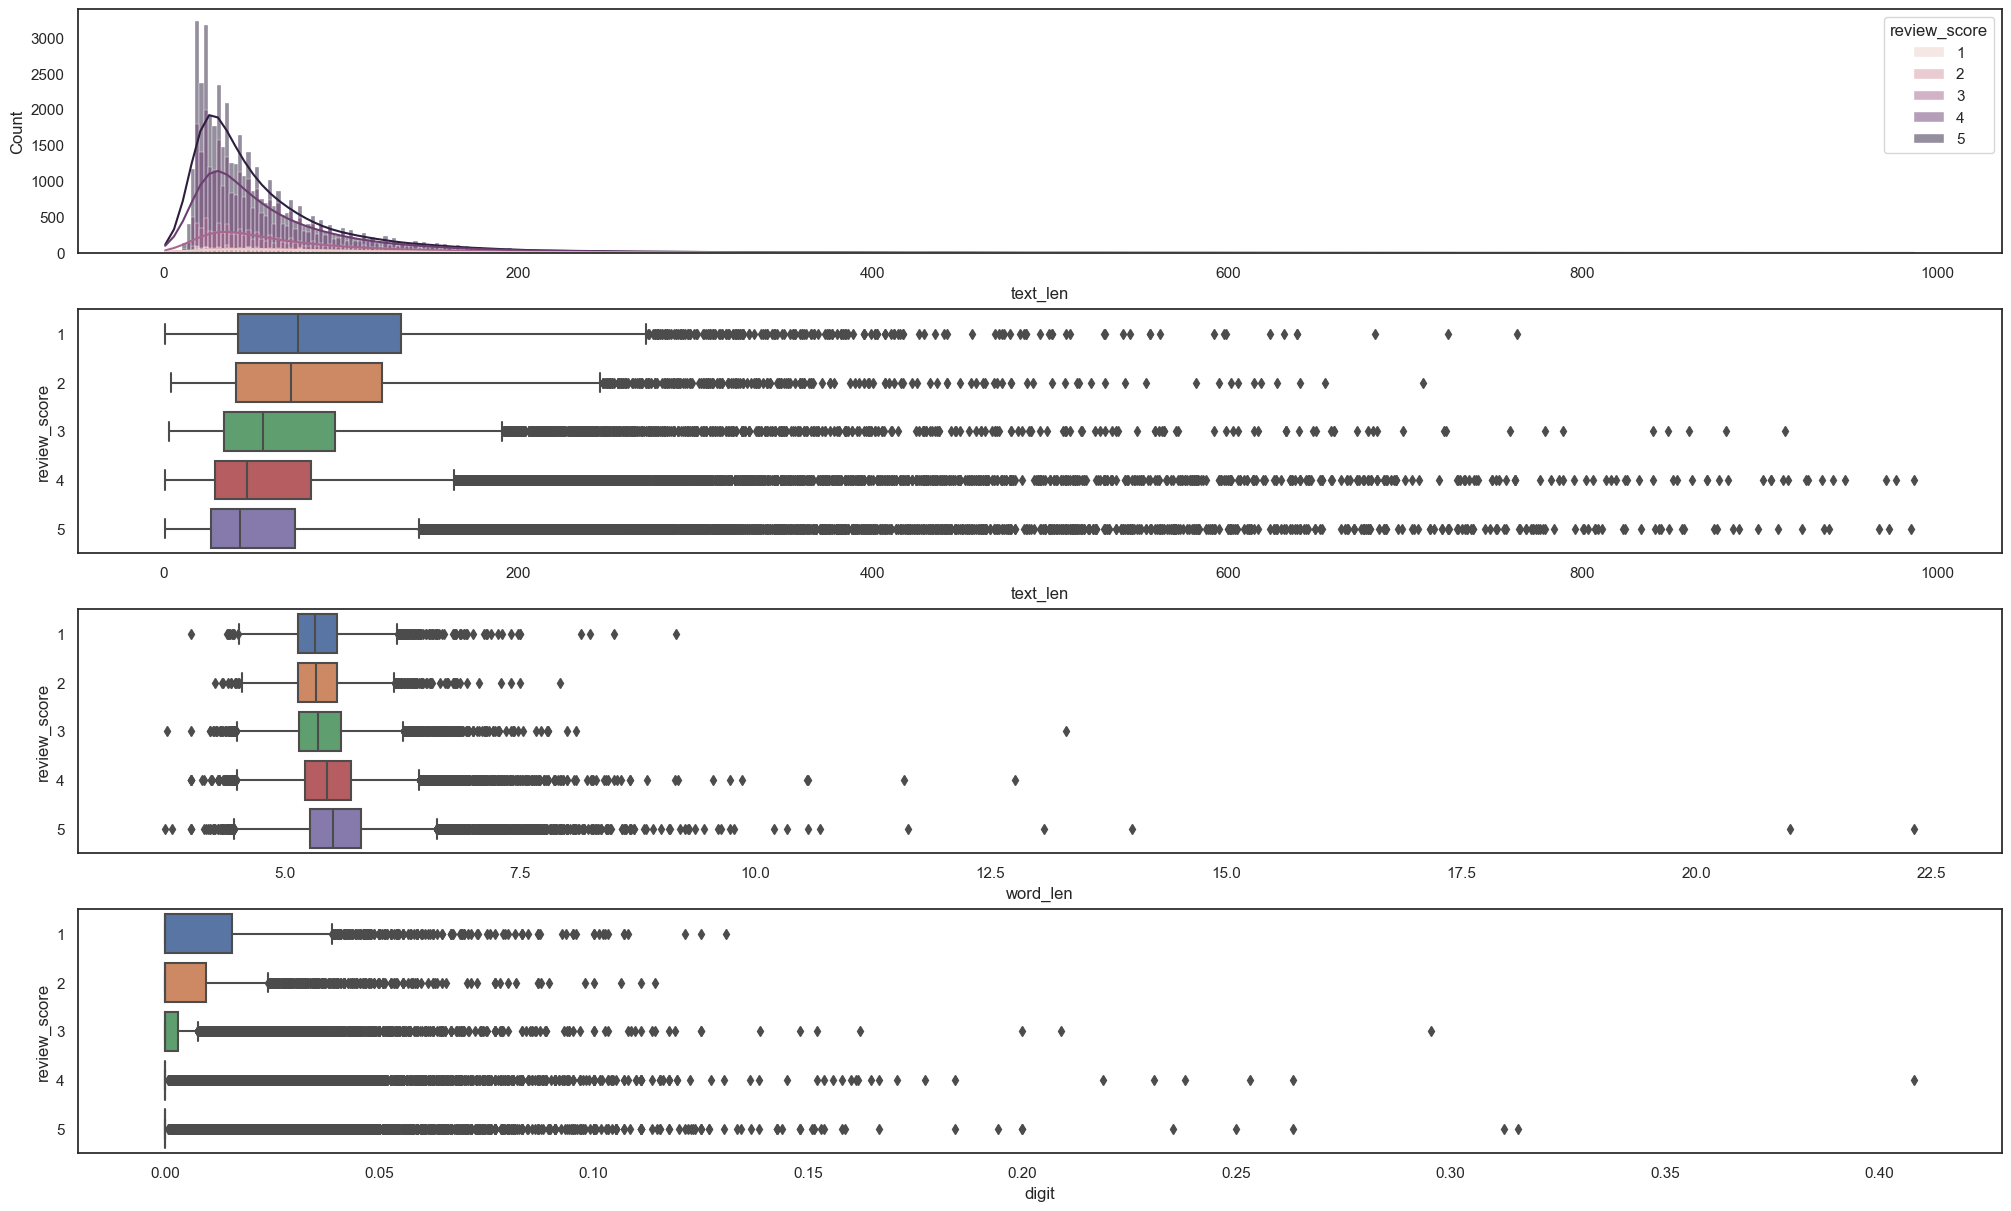

In [287]:
# 可視化1（diff_lenとcharacter_count以外）

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12), layout='constrained')
df_ = df_train[df_train['text_len']<1000]
sns.histplot(data=df_, x='text_len', kde=True, hue='review_score', ax=ax1)
sns.boxplot(data=df_, x='text_len', y='review_score', orient='h', ax=ax2)
sns.boxplot(data=df_train, y='review_score', x='word_len', orient='h', ax=ax3)
sns.boxplot(data=df_train, y='review_score', x='digit', orient='h', ax=ax4)


,c_a,c_b,c_c,c_d,c_e,c_f,c_g,c_h,c_i,c_j,...,c_q,c_r,c_s,c_t,c_u,c_v,c_w,c_x,c_y,c_z
review_score,,,,,,,,,,,,,,,,,,,,,
1,0.072,0.013,0.022,0.037,0.106,0.019,0.016,0.040,0.058,0.001,...,0.001,0.039,0.051,0.079,0.022,0.012,0.020,0.002,0.017,9.069e-04
2,0.072,0.014,0.023,0.036,0.104,0.019,0.016,0.040,0.059,0.001,...,0.001,0.038,0.052,0.080,0.023,0.012,0.020,0.002,0.017,8.927e-04
3,0.074,0.013,0.025,0.036,0.103,0.020,0.017,0.039,0.061,0.002,...,0.002,0.038,0.053,0.077,0.023,0.013,0.018,0.002,0.016,1.158e-03
4,0.076,0.012,0.027,0.037,0.102,0.021,0.017,0.038,0.064,0.002,...,0.001,0.039,0.053,0.072,0.023,0.013,0.016,0.002,0.017,1.467e-03
5,0.077,0.012,0.026,0.036,0.105,0.022,0.017,0.038,0.063,0.002,...,0.001,0.039,0.052,0.070,0.023,0.014,0.016,0.002,0.019,1.784e-03


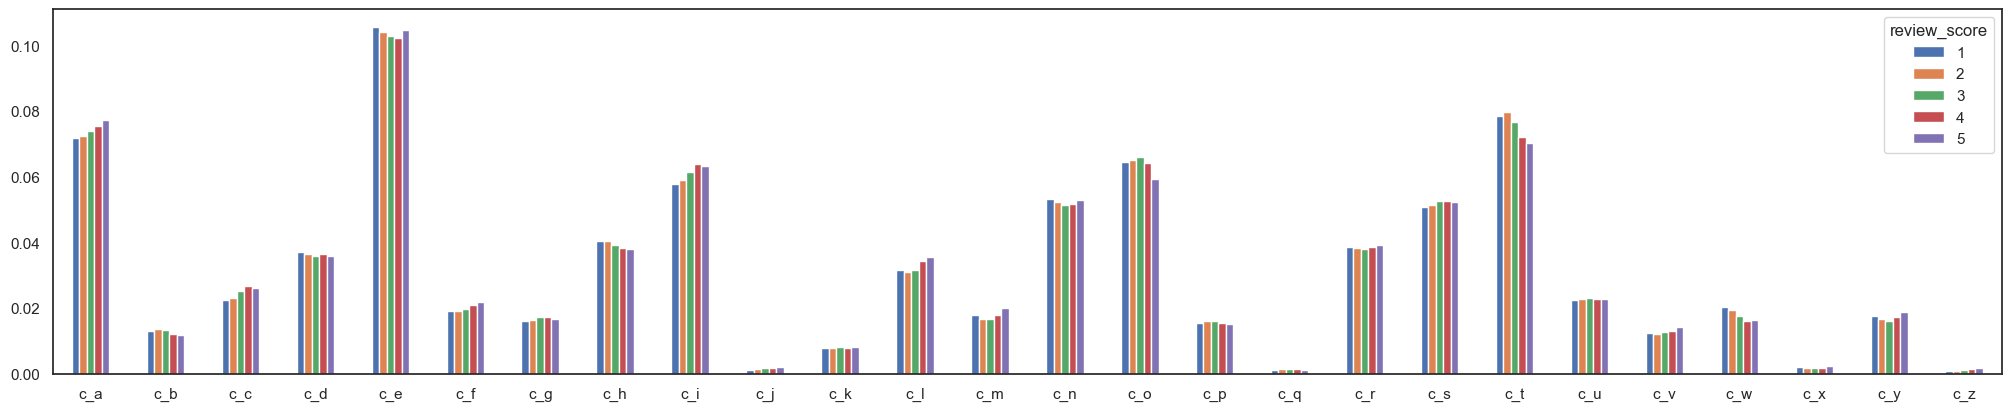

In [317]:
# 可視化2(character_count)

letter = ['c_' + i for i in iter(string.ascii_lowercase)]
fig, ax = plt.subplots(figsize=(20, 4), layout='constrained')
df_train.groupby('review_score')[letter].mean().T.plot(kind='bar', ax=ax)
ax.tick_params(axis='x', rotation=0)

display(df_train.groupby('review_score')[letter].mean())

# 束ねたときのグラフの切り口に右肩上がり（高評価）と左肩上がり（低評価）の違いがみられる。

In [289]:
# df_fw (df_trainから頻出wordのスコア別頻度表を作成)

df_fw = pd.DataFrame()
scores = set(df_train['review_score'])

for score in scores:
    data = df_train[df_train['review_score'] == score]
    text = ' '.join([i for i in data['clean_text']])
    text1 = Counter(text.split()).most_common()[:4000]
    for j in text1:
        df_fw.loc[j[0], 'score' + str(score)] = j[1] * 100000 / len(text)
    print(f'score{score}: {len(text)} words ')
df_fw = df_fw.fillna(0)
df_fw

# あとでword毎の特徴量を追加するので、計算速度とともに計算量（メモリ）を気にする必要がある
# データが多いほど精度は上がるが、限界があるのとあまり頻度が低いものは過学習のリスクもある

score1: 1601962 words 
score2: 1562368 words 
score3: 4403812 words 
score4: 12809801 words 
score5: 16754075 words 


,score1,score2,score3,score4,score5
the,944.155,1049.433,1037.488,974.597,936.292
and,576.044,554.159,565.896,668.402,734.460
to,515.992,476.840,411.507,358.288,374.715
was,390.271,431.844,393.273,307.140,303.383
a,383.592,420.195,459.307,487.252,423.443
...,...,...,...,...,...
sui,0.000,0.000,0.000,0.000,0.233
bent,0.000,0.000,0.000,0.000,0.233
unobtrusive,0.000,0.000,0.000,0.000,0.233
masterpiece,0.000,0.000,0.000,0.000,0.233


In [290]:
# (df_fw) ng_ratio

df_fw['ng_ratio'] = df_fw.apply(lambda x:
    ((x['score1'] * 3 + x['score2'] * 2 + x['score3']) / 6
     / ((x['score4'] + x['score5']) / 2)), axis=1)
df_fw['ng_ratio'] = df_fw['ng_ratio'].replace(np.inf, 10)

# 平均が4台なので、3以下は何某かのネガティブなニュアンスがあるスコア
# 1～3に重みの差をつけてポジティブ（4，5）との比率を算出

In [291]:
# (df_fw) ps_ratio

df_fw['ps_ratio'] = df_fw.apply(lambda x:
    ((x['score4'] + x['score5'] * 2) / 3)
    / ((x['score1'] + x['score2'] + x['score3']) / 3), axis=1)
df_fw['ps_ratio'] = df_fw['ps_ratio'].replace(np.inf, 10)

# 同じくポジティブ4，5に重み差をつけて、ネガティブとの比率を算出

### 実は、ここが先週との大きな認識の違いの部分<br>
pred_scoreではなくword_scoreだったということ。<br>
平均が3に寄るのは当然。だから特徴量に貢献しないwordを省くという発想に繋がった。

In [292]:
# (df_fw) word_score

df_fw['word_score'] = df_fw.apply(lambda x:
    (x['score1'] * 1 + x['score2'] * 2 + x['score3'] * 3 + x['score4'] * 4 + x['score5'] * 5)
    / (x['score1'] + x['score2'] + x['score3'] + x['score4'] + x['score5']), axis=1)

display(df_fw)
display(df_fw[df_fw['word_score']==1])

# このあとの可視化ご参照


,score1,score2,score3,score4,score5,ng_ratio,ps_ratio,word_score
the,944.155,1049.433,1037.488,974.597,936.292,1.041,0.939,2.982
and,576.044,554.159,565.896,668.402,734.460,0.808,1.260,3.139
to,515.992,476.840,411.507,358.288,374.715,1.325,0.789,2.812
was,390.271,431.844,393.273,307.140,303.383,1.326,0.752,2.837
a,383.592,420.195,459.307,487.252,423.443,0.897,1.056,3.068
...,...,...,...,...,...,...,...,...
sui,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000
bent,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000
unobtrusive,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000
masterpiece,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000


,score1,score2,score3,score4,score5,ng_ratio,ps_ratio,word_score
police,1.436,0.0,0.0,0.0,0.0,10.0,0.0,1.0
rat,1.373,0.0,0.0,0.0,0.0,10.0,0.0,1.0
coupon,1.248,0.0,0.0,0.0,0.0,10.0,0.0,1.0
confronted,1.124,0.0,0.0,0.0,0.0,10.0,0.0,1.0
scam,1.124,0.0,0.0,0.0,0.0,10.0,0.0,1.0
...,...,...,...,...,...,...,...,...
wake,0.250,0.0,0.0,0.0,0.0,10.0,0.0,1.0
diarrhoea,0.250,0.0,0.0,0.0,0.0,10.0,0.0,1.0
denying,0.250,0.0,0.0,0.0,0.0,10.0,0.0,1.0
expression,0.250,0.0,0.0,0.0,0.0,10.0,0.0,1.0


In [293]:
# (df_fw) 各スコアにしか出てこないword

#dic_only = defaultdict(list)
#mask = (df_fw.iloc[:,:5] > 0).sum(axis=1) == 1
#tmp = df_fw.iloc[:,:5][mask]

#for column in tmp.columns:
#    words = tmp.index[tmp[column] > 0].tolist()
#    dic_only[column].extend(words)

#pprint(dic_only['score2'], compact=True)

# 各スコアに単独で出現するwordを特定しようと別コードを書いたが、
# word_scoreが1～5丁度のものが該当wordなので不要と判断。

,score1,score2,score3,score4,score5,ng_ratio,ps_ratio,word_score
count,6163.000,6163.000,6163.000,6163.000,6163.000,6163.000,6163.000,6163.000
mean,2.886,2.874,2.840,2.788,2.751,3.498,2.183,2.909
std,21.260,21.994,21.867,21.490,21.175,4.649,3.236,1.076
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,0.000,0.000,0.000,0.000,0.000,0.382,0.000,2.062
50%,0.375,0.384,0.363,0.359,0.358,1.080,0.882,2.992
75%,1.061,1.024,1.045,1.062,1.021,10.000,2.143,3.603
max,944.155,1049.433,1037.488,974.597,936.292,136.539,17.873,5.000


<Axes: >

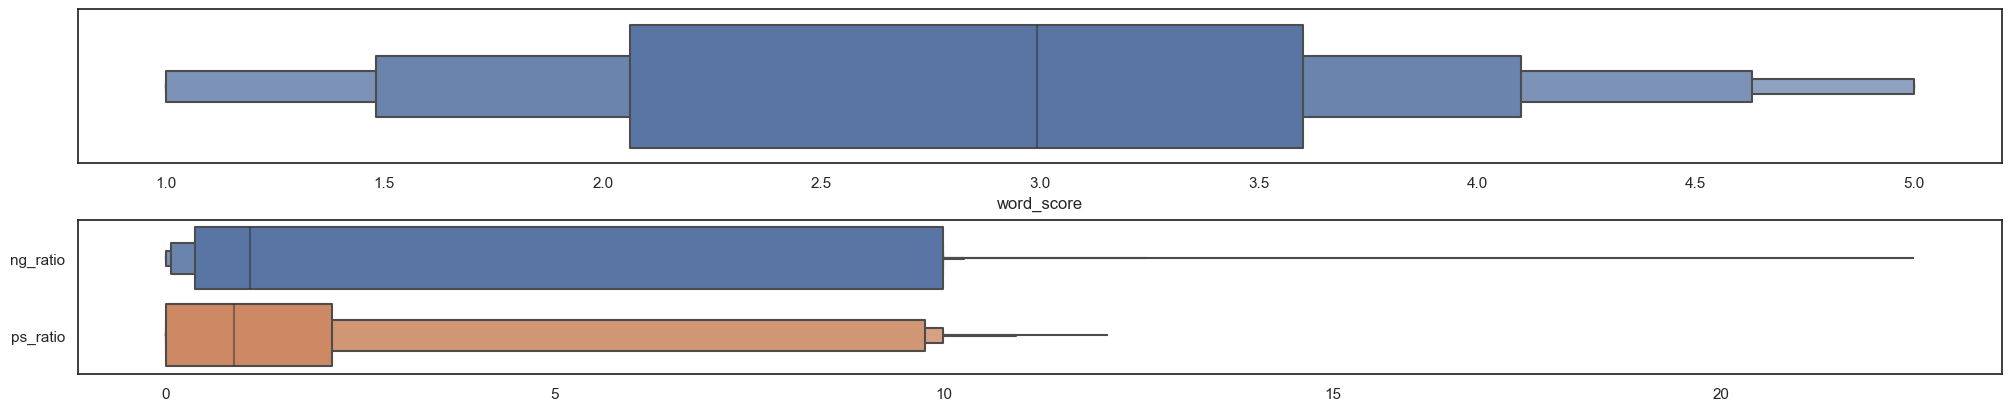

In [294]:
# 可視化

display(df_fw.describe())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,4), layout='constrained')
sns.boxenplot(data=df_fw, x='word_score', orient='h', ax=ax1)
sns.boxenplot(data=df_fw[['ng_ratio', 'ps_ratio']], orient='h', showfliers=False, ax=ax2)

# word_scoreの平均が3近辺で数が多いのは、実際にそうだからということが分かった。
# 特徴量を捉える観点からは、頻出単語である3付近は逆にあまり意味がない。⇒取り除くことが可能

In [295]:
# 中間wordの除外
df_fw_core = df_fw[(df_fw['word_score'] < 2.8) | (df_fw['word_score'] > 3.2)]
display(df_fw_core)
display(df_fw_core.describe())

# 中間wordを削ることで、6100words ⇒ 5100words程度に削減（バリデーションデータとの切り分け次第で変化）
# 実際、境界線近くのwordに意味があると思われるが、3に近づくほどその数値は偶然の要素が高くなる。
# 先週は3文字以上といった割り切りを行ったが、こちらの方が合理的。1文字2文字でも重要で高頻度なwordがある。

,score1,score2,score3,score4,score5,ng_ratio,ps_ratio,word_score
i,350.196,291.481,245.560,210.448,236.289,1.402,0.770,2.768
we,251.130,234.836,183.727,162.649,168.281,1.417,0.745,2.762
is,218.981,254.229,358.825,387.914,343.218,0.695,1.291,3.244
not,194.449,218.130,177.732,88.737,57.831,2.723,0.346,2.454
that,173.600,152.333,117.898,89.150,82.475,1.832,0.573,2.601
...,...,...,...,...,...,...,...,...
sui,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000
bent,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000
unobtrusive,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000
masterpiece,0.000,0.000,0.000,0.000,0.233,0.000,10.000,5.000


,score1,score2,score3,score4,score5,ng_ratio,ps_ratio,word_score
count,5107.000,5107.000,5107.000,5107.000,5107.000,5107.000,5107.000,5107.000
mean,1.754,1.676,1.622,1.611,1.614,3.801,2.456,2.891
std,9.920,9.655,9.862,9.674,9.216,4.886,3.488,1.180
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,0.000,0.000,0.000,0.000,0.000,0.286,0.000,2.000
50%,0.312,0.320,0.295,0.304,0.310,1.394,0.766,2.765
75%,0.874,0.832,0.817,0.835,0.854,10.000,2.805,3.786
max,350.196,291.481,358.825,387.914,343.218,136.539,17.873,5.000


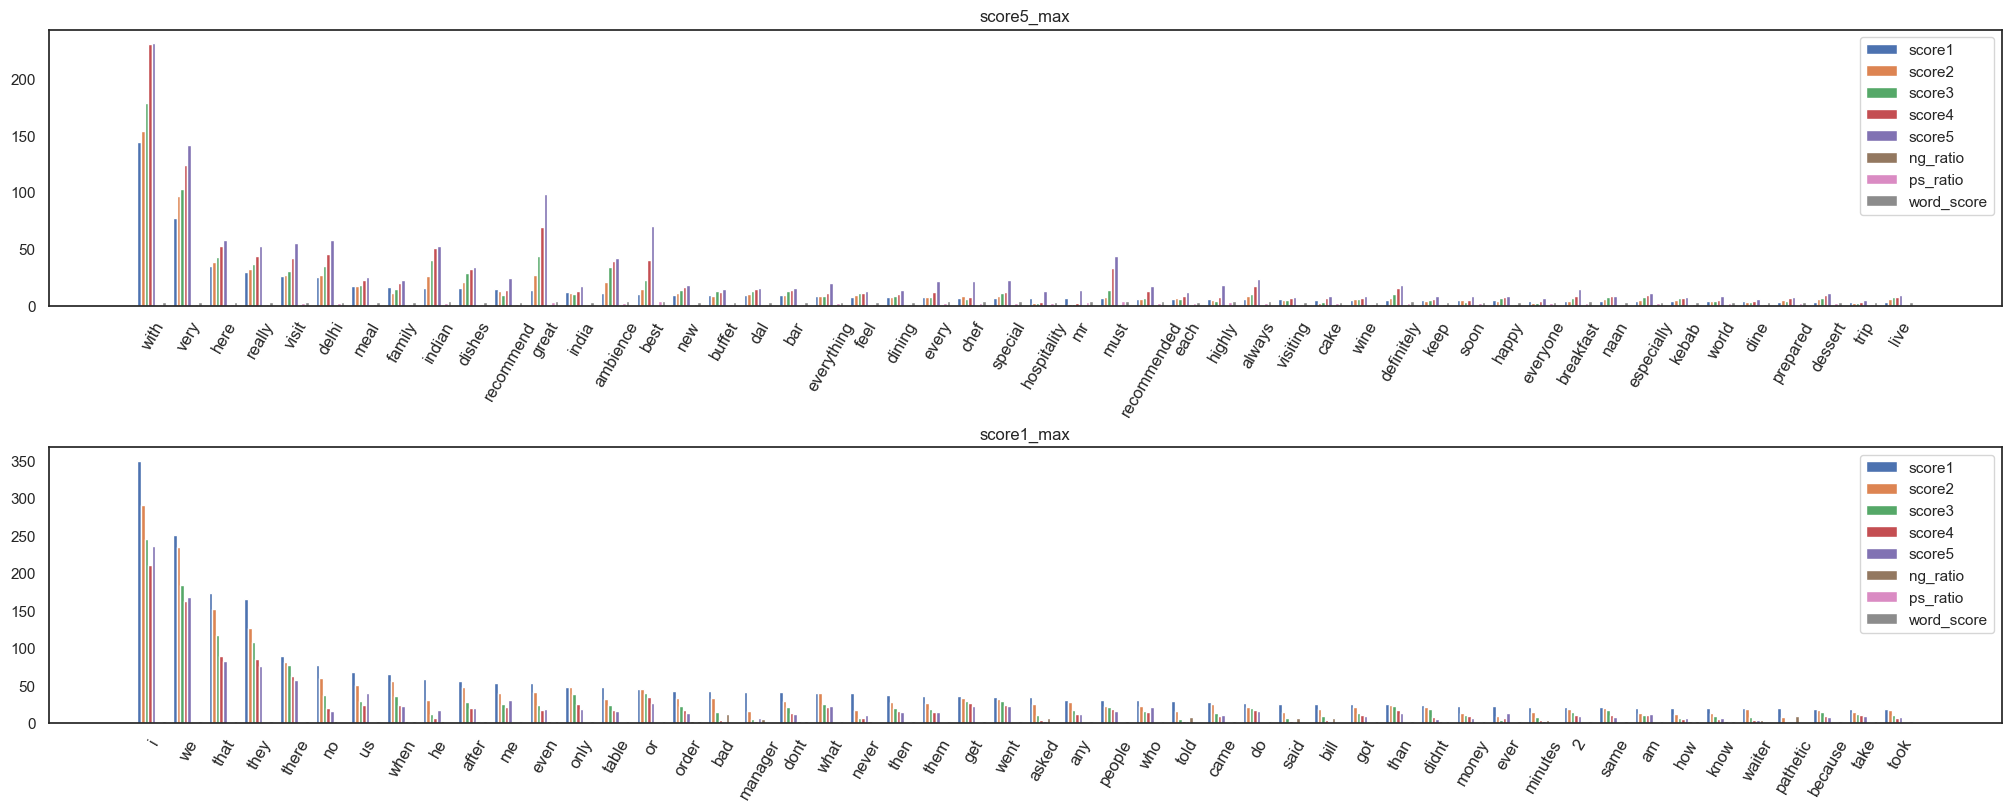

In [296]:
# 可視化
app = 50

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), layout='constrained')

df_fw5 = df_fw_core[df_fw_core.T.idxmax() == 'score5']
x = np.arange(len(df_fw5.index[:app]))
width = 0.8 / len(df_fw5.columns)
for i, c in enumerate(df_fw5.columns):
    pos = -0.4 + width * i
    ax1.bar(x + pos, df_fw5.loc[df_fw5.index[:app], c].T,
           width=width, label=c)
ax1.set_xticks(x)
ax1.set_xticklabels(df_fw5.index[:app])
ax1.tick_params(axis='x', rotation=60, labelsize=12)
ax1.set_title('score5_max')
ax1.legend()

df_fw1 = df_fw_core[df_fw_core.T.idxmax() == 'score1']
x = np.arange(len(df_fw1.index[:app]))
width = 0.8 / len(df_fw1.columns)
for i, c in enumerate(df_fw1.columns):
    pos = -0.4 + width * i
    ax2.bar(x + pos, df_fw1.loc[df_fw1.index[:app], c].T,
           width=width, label=c)
ax2.set_xticks(x)
ax2.set_xticklabels(df_fw1.index[:app])
ax2.tick_params(axis='x', rotation=60, labelsize=12)
ax2.set_title('score1_max')
ax2.legend()

# 出現頻度順に並べてみると（各スコア上位4000語）低評価で出現率が突出する明らかなネガティブワードがあることが分かる。
# 必ずしもそのword自体に否定的な意味はなくてもwordの対象に文句があるときに出てき易い語句と推測できる ⇒ 「レビュースコアに影響する因子」
# 人称代名詞や no, when, after, even, table, order, manager, bad, dont, never, asked, worst, told, said, bill, got, money, minutes, waiterなど
# 味や価格に関するものもみられるが、スタッフやマネージャーの接客態度などに関するクレームが多いことが分かる。
# 逆に高評価の方はgreat, best, must, hightlyなど、普通に良さそうな意味のものが並ぶ。

In [297]:
# 辞書化（メモリは食うが予め辞書にしておく方がコードが見やすく計算が少し早い）
dic_ng = defaultdict(int)
dic_ps = defaultdict(int)
dic_ws = defaultdict(int)

for word in df_fw_core.index:
    dic_ng[word] = df_fw_core.at[word, 'ng_ratio']
    dic_ps[word] = df_fw_core.at[word, 'ps_ratio']
    dic_ws[word] = df_fw_core.at[word, 'word_score']

In [298]:
# 特徴量 word_score_mean2

df_train['word_score_mean'] = df_train['clean_text'].apply(lambda x:
    np.mean([dic_ws[word] for word in set(x.split()) & set(df_fw_core.index)]))
df_val['word_score_mean'] = df_val['clean_text'].apply(lambda x: 
    np.mean([dic_ws[word] for word in set(x.split()) & set(df_fw_core.index)]))

df_train = df_train.fillna(0)
df_val = df_val.fillna(0)


In [299]:
# ng_word, ps_wordのraio別配列（set）

ng_word = defaultdict(set)
for ratio in range(2, 21):
    ng_word[ratio] = set(df_fw_core[df_fw_core['ng_ratio'] >= ratio].index)

ps_word = defaultdict(set)
for ratio in range(2, 21):
    ps_word[ratio] = set(df_fw_core[df_fw_core['ps_ratio'] >= ratio].index)

pprint(ng_word[20], compact=True)
pprint(ps_word[20], compact=True)


{'sad', 'rude', 'poor', 'mediocre', 'terrible', 'dirty', 'worst', 'worse'}
set()


In [300]:
# 特徴量 ng_n, ps_n: 重み付き頻度別スコア合計

for i in range(2, 21, 2):
    df_train['ng' + str(i)] = df_train['clean_text'].apply(lambda x:
        np.sum([dic_ng[word] for word in set(x.split()) & set(ng_word[i])], 0))
    df_val['ng' + str(i)] = df_val['clean_text'].apply(lambda x:
        np.sum([dic_ng[word] for word in set(x.split()) & set(ng_word[i])], 0))

for i in range(2, 21, 2):
    df_train['ps' + str(i)] = df_train['clean_text'].apply(lambda x:
        np.sum([dic_ps[word] for word in set(x.split()) & set(ps_word[i])], 0))
    df_val['ps' + str(i)] = df_val['clean_text'].apply(lambda x: 
        np.sum([dic_ps[word] for word in set(x.split()) & set(ps_word[i])], 0))

display(df_train[df_train['review_score'] == 5])
display(df_train[df_train['review_score'] == 1])

# ネガティブだけでなくポジティブについても特徴量化
# 先週は数だけだったが、各々のwordのps_ratio, ng_ratioの合計とすることでより細かく表現した。

,index,review_text,review_score,clean_text,text_len,diff_len,word_len,digit,c_a,c_b,...,ps2,ps4,ps6,ps8,ps10,ps12,ps14,ps16,ps18,ps20
101575,98993,Had a great dining experience here. Food was g...,5,had a great dining experience here food was gr...,35,0,5.857,0.000,0.100,0.000,...,30.224,17.941,7.503,0.000,0.000,0.000,0.0,0.0,0.0,0.0
6473,125948,"favorites - mini idli with ghee,dosa are best ...",5,favorites mini idli with gheedosa are best in ...,42,0,5.452,0.000,0.058,0.013,...,52.686,30.426,30.426,30.426,30.426,0.000,0.0,0.0,0.0,0.0
44906,135552,These guys do the absolute best rolls in Saket...,5,these guys do the absolute best rolls in saket...,67,0,5.194,0.000,0.087,0.012,...,18.212,4.603,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0
45522,24038,We're staying in the hotel and didn't want to ...,5,were staying in the hotel and didnt want to go...,99,0,5.030,0.000,0.075,0.008,...,66.648,45.149,40.000,40.000,40.000,0.000,0.0,0.0,0.0,0.0
74876,106829,We could hardly get reservations but finally w...,5,we could hardly get reservations but finally w...,86,0,5.349,0.012,0.081,0.013,...,26.734,14.226,14.226,8.215,0.000,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40880,146498,Jyoti was very attentive and helpful. She ensu...,5,jyoti was very attentive and helpful she ensur...,67,0,5.910,0.000,0.068,0.015,...,57.437,36.089,25.291,18.495,10.000,0.000,0.0,0.0,0.0,0.0
293,28365,We visited this restaurant at midday after a l...,5,we visited this restaurant at midday after a l...,98,0,5.204,0.000,0.096,0.008,...,51.448,38.888,20.000,20.000,20.000,0.000,0.0,0.0,0.0,0.0
34039,83789,Recently ordered food from this place. Very de...,5,recently ordered food from this place very dec...,51,0,5.510,0.078,0.062,0.004,...,12.513,12.513,12.513,12.513,12.513,12.513,0.0,0.0,0.0,0.0
82989,65482,Civil house:::::::: Insta: bhukkadbros This w...,5,civil house insta bhukkadbros this was my firs...,69,0,6.188,0.130,0.076,0.014,...,64.773,44.038,40.000,40.000,40.000,0.000,0.0,0.0,0.0,0.0


,index,review_text,review_score,clean_text,text_len,diff_len,word_len,digit,c_a,c_b,...,ps2,ps4,ps6,ps8,ps10,ps12,ps14,ps16,ps18,ps20
63625,126725,Well as I say it is completely different with ...,1,well as i say it is completely different with ...,71,0,5.070,0.028,0.064,0.008,...,7.500,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
112425,133513,A small restaurant and sweet meat shop in Bhar...,1,a small restaurant and sweet meat shop in bhar...,17,0,6.176,0.000,0.117,0.019,...,12.033,10.000,10.000,10.000,10.0,0.0,0.0,0.0,0.0,0.0
7440,78405,"The title sais everything, it looks nice and f...",1,the title sais everything it looks nice and fa...,70,0,5.157,0.014,0.059,0.008,...,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
58234,105966,This place has lost his charm. They used to se...,1,this place has lost his charm they used to ser...,18,0,5.444,0.000,0.071,0.010,...,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
95678,89146,Friends if you are really looking for a nice p...,1,friends if you are really looking for a nice p...,192,0,5.016,0.000,0.077,0.008,...,4.188,4.188,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727,77744,"Fresco- Ambi mall, vasant kunj. Had heard that...",1,fresco ambi mall vasant kunj had heard that th...,315,0,5.067,0.013,0.074,0.015,...,18.597,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
62948,132854,Very Very bad experience .. literately wastage...,1,very very bad experience literately wastage of...,97,0,5.175,0.000,0.087,0.010,...,3.431,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
41784,104251,This was my second visit to the place and simi...,1,this was my second visit to the place and simi...,158,0,4.924,0.000,0.085,0.014,...,5.232,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0
108414,34884,went to this restaurant nearly after a year wh...,1,went to this restaurant nearly after a year wh...,101,0,5.812,0.000,0.072,0.014,...,13.054,8.215,8.215,8.215,0.0,0.0,0.0,0.0,0.0,0.0


In [301]:
# 特徴量 words(df_fw_coreのng_ratioをプロット)3

#new_columns  = [i for i in df_fw_core.index]

#df_train[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)
#df_val[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df_val.index)

#df_train.iloc[:, 27:] = df_train.apply(lambda x: dic_ng[x.name] if x['clean_text'].contains(x.name) else 0, axis=1)
#df_val.iloc[:, 27:] = df_val.apply(lambda x: dic_ng[x.name] if x['clean_text'].contains(x.name) else 0, axis=1)

# 2と3の違いは計算方法。
# 3はfor文を使用しておらず速いと思って書いたが、applyは内部でfor文を回しており、却って遅かったためボツに。

In [302]:
# 特徴量 words(df_fw_coreのword_scoreをプロット)2

new_columns  = [i for i in df_fw_core.index]

df_train[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df.index)
df_val[new_columns] = pd.DataFrame([[0] * len(new_columns)], index=df_val.index)

for col in df_train.columns[55:]:
    mask = df_train['clean_text'].str.contains(col)
    df_train.loc[mask, col] = dic_ws[col]

for col in df_val.columns[55:]:
    mask = df_val['clean_text'].str.contains(col)
    df_val.loc[mask, col] = dic_ws[col]

# 最後に個別wordのword_scoreを特徴量に加える。
# 先週は割り切りで5000語で切っていたが、今週は最初から5000語台で進めているのでそのまま使う
# また、先週はng_ratioを使ったが、word_scoreに変更（結果に大差ないが、意味的に中立な概念を使った）

In [303]:
# 特徴量削除

df_train = df_train.drop(columns=['index','review_text', 'clean_text'])
df_val = df_val.drop(columns=['index','review_text', 'clean_text'])

In [304]:
display(df_train[df_train['review_score'] == 5])
display(df_train[df_train['review_score'] == 1])

,review_score,text_len,diff_len,word_len,digit,c_a,c_b,c_c,c_d,c_e,...,ravinder,malleshwaram,ming,payasam,matching,sui,bent,unobtrusive,masterpiece,decadent
101575,5,35,0,5.857,0.000,0.100,0.000,0.025,0.040,0.134,...,0.0,0.0,0,0,0,0,0,0,0,0
6473,5,42,0,5.452,0.000,0.058,0.013,0.013,0.018,0.111,...,0.0,0.0,0,0,0,0,0,0,0,0
44906,5,67,0,5.194,0.000,0.087,0.012,0.012,0.026,0.105,...,0.0,0.0,0,0,0,0,0,0,0,0
45522,5,99,0,5.030,0.000,0.075,0.008,0.014,0.043,0.104,...,0.0,0.0,0,0,0,0,0,0,0,0
74876,5,86,0,5.349,0.012,0.081,0.013,0.029,0.042,0.105,...,0.0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40880,5,67,0,5.910,0.000,0.068,0.015,0.030,0.045,0.101,...,0.0,0.0,0,0,0,0,0,0,0,0
293,5,98,0,5.204,0.000,0.096,0.008,0.024,0.040,0.114,...,0.0,0.0,0,0,0,0,0,0,0,0
34039,5,51,0,5.510,0.078,0.062,0.004,0.062,0.048,0.114,...,0.0,0.0,0,0,0,0,0,0,0,0
82989,5,69,0,6.188,0.130,0.076,0.014,0.038,0.036,0.102,...,0.0,0.0,0,0,0,0,0,0,0,0


,review_score,text_len,diff_len,word_len,digit,c_a,c_b,c_c,c_d,c_e,...,ravinder,malleshwaram,ming,payasam,matching,sui,bent,unobtrusive,masterpiece,decadent
63625,1,71,0,5.070,0.028,0.064,0.008,0.014,0.028,0.086,...,0.0,0.0,0,0,0,0,0,0,0,0
112425,1,17,0,6.176,0.000,0.117,0.019,0.010,0.029,0.087,...,0.0,0.0,0,0,0,0,0,0,0,0
7440,1,70,0,5.157,0.014,0.059,0.008,0.020,0.045,0.113,...,0.0,0.0,0,0,0,0,0,0,0,0
58234,1,18,0,5.444,0.000,0.071,0.010,0.020,0.051,0.102,...,0.0,0.0,0,0,0,0,0,0,0,0
95678,1,192,0,5.016,0.000,0.077,0.008,0.022,0.038,0.119,...,0.0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727,1,315,0,5.067,0.013,0.074,0.015,0.023,0.050,0.117,...,0.0,0.0,0,0,0,0,0,0,0,0
62948,1,97,0,5.175,0.000,0.087,0.010,0.021,0.029,0.095,...,0.0,0.0,0,0,0,0,0,0,0,0
41784,1,158,0,4.924,0.000,0.085,0.014,0.020,0.042,0.097,...,0.0,0.0,0,0,0,0,0,0,0,0
108414,1,101,0,5.812,0.000,0.072,0.014,0.027,0.030,0.095,...,0.0,0.0,0,0,0,0,0,0,0,0


## 機械学習モデルの適用

In [305]:
X_train = df_train.drop(columns='review_score')
y_train = df_train['review_score']
X_val = df_val.drop(columns='review_score')
y_test = df_val['review_score']

In [306]:
# 標準化

#X_train = stats.zscore(X_train)
#X_val = stats.zscore(X_val)

#X_train = X_train.fillna(0)
#X_val = X_val.fillna(0)

# linear_modelを使う場合は標準化を行う。

In [307]:
display(X_train)

,text_len,diff_len,word_len,digit,c_a,c_b,c_c,c_d,c_e,c_f,...,ravinder,malleshwaram,ming,payasam,matching,sui,bent,unobtrusive,masterpiece,decadent
39303,71,0,5.127,0.014,0.058,0.008,0.017,0.042,0.114,0.022,...,0.0,0.0,0,0,0,0,0,0,0,0
101575,35,0,5.857,0.000,0.100,0.000,0.025,0.040,0.134,0.025,...,0.0,0.0,0,0,0,0,0,0,0,0
6473,42,0,5.452,0.000,0.058,0.013,0.013,0.018,0.111,0.027,...,0.0,0.0,0,0,0,0,0,0,0,0
50170,27,0,6.074,0.000,0.087,0.013,0.025,0.037,0.131,0.006,...,0.0,0.0,0,0,0,0,0,0,0,0
12335,55,0,4.945,0.000,0.069,0.004,0.027,0.065,0.111,0.038,...,0.0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,66,0,5.379,0.000,0.106,0.011,0.043,0.046,0.066,0.014,...,0.0,0.0,0,0,0,0,0,0,0,0
61493,94,0,5.734,0.000,0.085,0.008,0.013,0.028,0.112,0.036,...,0.0,0.0,5,0,0,0,0,0,0,0
82989,69,0,6.188,0.130,0.076,0.014,0.038,0.036,0.102,0.014,...,0.0,0.0,0,0,0,0,0,0,0,0
38872,43,0,6.093,0.000,0.054,0.008,0.035,0.054,0.105,0.023,...,0.0,0.0,0,0,0,0,0,0,0,0


In [308]:
# 重回帰

#LR_model = LR()
#LR_model.fit(X_train, y_train)
#LR_pred_train = LR_model.predict(X_train)
#LR_pred_test = LR_model.predict(X_val)

# RMSE

#print(np.sqrt(mean_squared_error(LR_pred_test, y_test)))
#LR_pred_test = LR_pred_test.round(0)
#print(np.sqrt(mean_squared_error(LR_pred_test, y_test)))


In [309]:
# SVR

#SVR_model = SVR()
#SVR_model.fit(X_train, y_train)
#SVR_pred_train = SVR_model.predict(X_train)
#SVR_pred_test = SVR_model.predict(X_val)

# RMSE

#print(np.sqrt(mean_squared_error(SVR_pred_test, y_test)))
#SVR_pred_test = SVR_pred_test.round(0)
#print(np.sqrt(mean_squared_error(SVR_pred_test, y_test)))

# SVRは計算が終わらなかった・・・・

In [310]:
# RFG

#RFG_model = RFG()
#RFG_model.fit(X_train, y_train)
#RFG_pred_train = RFG_model.predict(X_train)
#RFG_pred_test = RFG_model.predict(X_val)

# RMSE

#print(np.sqrt(mean_squared_error(RFG_pred_test, y_test)))
#RFG_pred_test = RFG_pred_test.round(0)
#print(np.sqrt(mean_squared_error(RFG_pred_test, y_test)))


In [311]:
# Light GBM

params = {"objective": "regression","metrics": "rmse"}
trains = lgb.Dataset(X_train, y_train)
valids = lgb.Dataset(X_val, y_test)
lgb_model = lgb.train(params, trains, valid_sets=valids,
                      num_boost_round=1000, early_stopping_rounds=100)

lgb_pred = lgb_model.predict(X_val)

print(np.sqrt(mean_squared_error(lgb_pred, y_test)))

lgb_pred_round = lgb_pred.round(0)
print(np.sqrt(mean_squared_error(lgb_pred_round, y_test)))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.525721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20338
[LightGBM] [Info] Number of data points in the train set: 94449, number of used features: 4927
[LightGBM] [Info] Start training from score 4.228780
[1]	valid_0's rmse: 0.917775
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.877625
[3]	valid_0's rmse: 0.84329
[4]	valid_0's rmse: 0.813954
[5]	valid_0's rmse: 0.789456
[6]	valid_0's rmse: 0.768381
[7]	valid_0's rmse: 0.750645
[8]	valid_0's rmse: 0.735719
[9]	valid_0's rmse: 0.723194
[10]	valid_0's rmse: 0.712428
[11]	valid_0's rmse: 0.703429
[12]	valid_0's rmse: 0.69569
[13]	valid_0's rmse: 0.688926
[14]	valid_0's rmse: 0.683312
[15]	valid_0's rmse: 0.678571
[16]	valid_0's rmse: 0.674325
[17]	valid_0's rmse: 0.67065
[18]	valid_0's rmse: 0.66754

In [312]:
#pred_train = np.block([lgb_pred_train, SVR_pred_train, RFG_pred_train]).T
#pred_test = np.block([lgb_pred_test, SVR_pred_test, RFG_pred_test]).T

In [313]:
# meta_Light GBM

#params = {"objective": "regression","metrics": "rmse"}
#trains = lgb.Dataset(pred_train, y_train)
#valids = lgb.Dataset(pred_test, y_test)
#meta_lgb_model = lgb.train(params, trains, valid_sets=valids,
#                      num_boost_round=1000)

#meta_lgb_pred = meta_lgb_model.predict(pred_test)
#print(np.sqrt(mean_squared_error(meta_lgb_pred, y_test)))

#meta_lgb_pred = meta_lgb_pred.round(0)
#print(np.sqrt(mean_squared_error(meta_lgb_pred, y_test)))

# スタッキングは軽い仕様でいくつか試したが、パラメータ設定などが難しく今回はやり方だけ分かった感じ。

In [314]:

#lgb_pred = lgb_model.predict(X_val)
#lgb_pred = np.where((lgb_pred >=1.5) & (lgb_pred < 2.5),lgb_pred - 0.10, lgb_pred)
#lgb_pred = np.where((lgb_pred >=2.5) & (lgb_pred < 3.5),lgb_pred - 0.10, lgb_pred)
#lgb_pred = np.where((lgb_pred >=3.5) & (lgb_pred < 4.5),lgb_pred - 0.10, lgb_pred)
#lgb_pred = np.where((lgb_pred >=4.5) & (lgb_pred < 5.5),lgb_pred + 0.00, lgb_pred)
#lgb_pred = lgb_pred.round(0)
#print(np.sqrt(mean_squared_error(lgb_pred, y_test)))

# 整数に丸めるとスコアが0.6～0.7程度悪化する。
# 分布が偏っているためその調整を試みたが、このレベルの数理最適化問題を手動でやるのは無理。

pred                                      
pred          0.0    1.0    2.0     3.0     4.0     5.0
review_score                                           
1             3.0  220.0  298.0   128.0    37.0     4.0
2             NaN   66.0  254.0   252.0   133.0     4.0
3             NaN   22.0  224.0  1022.0  1257.0   106.0
4             NaN    2.0   37.0   454.0  5056.0  2477.0
5             NaN    NaN    6.0   112.0  3282.0  8157.0

(0.500, 5.500)

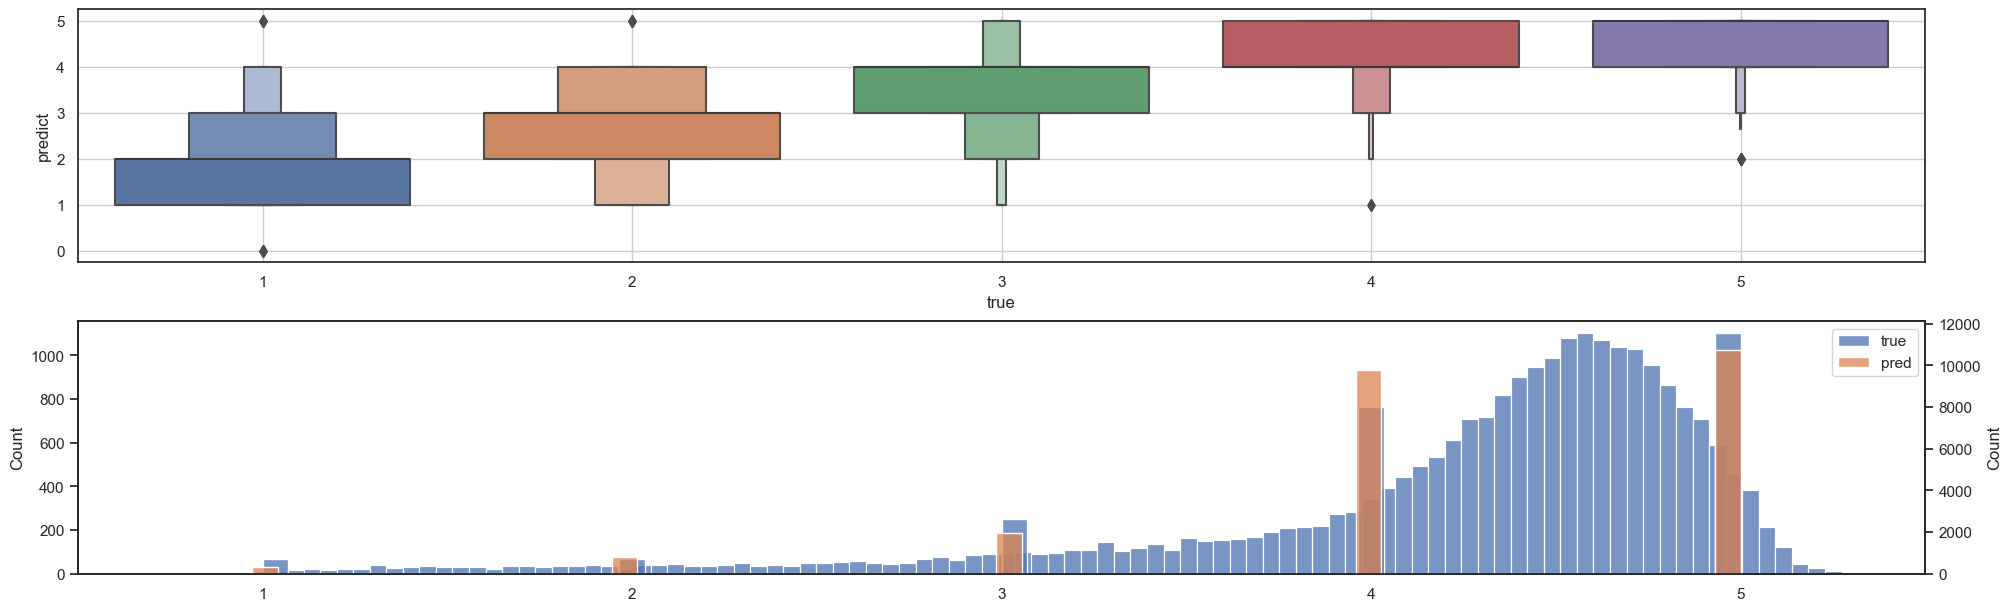

In [315]:
# 可視化

df_pred = pd.DataFrame(y_test)
df_pred['pred'] = lgb_pred_round
display(df_pred.groupby(['review_score', 'pred'])[['pred']].count().unstack())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6), layout='constrained')
sns.boxenplot(x=y_test, y=lgb_pred_round, ax=ax1)
ax1.grid()
ax1.set_xlabel('true')
ax1.set_ylabel('predict')
sns.histplot(lgb_pred, ax=ax2)
axt = ax2.twinx()
sns.histplot(y_test.values, label='true', ax=axt)
sns.histplot(lgb_pred_round, label='pred', ax=axt)
axt.legend()
ax2.set_xlim(0.5,5.5)


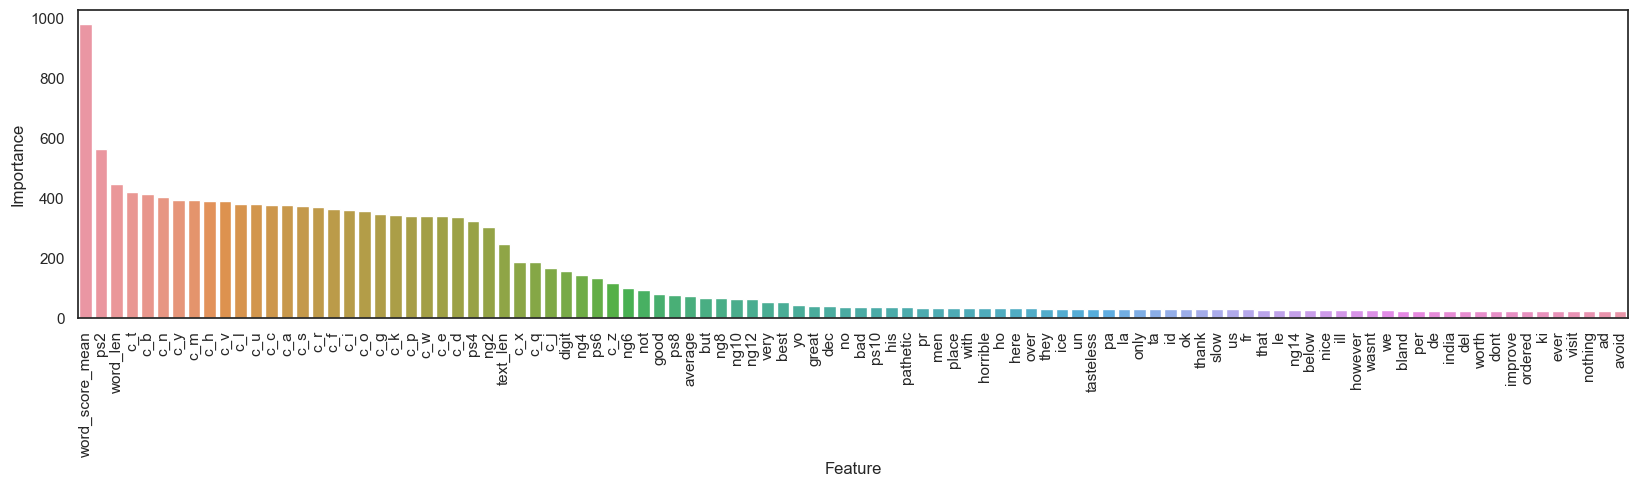

In [316]:
# 特徴量の重要度の可視化

importance = lgb_model.feature_importance()
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
fig, ax = plt.subplots(figsize=(20, 4))
sns.barplot(data=importance_df.iloc[:100, :], x='Feature', y='Importance', ax=ax)
ax.tick_params(axis='x', rotation=90)

# 「木系」のfeature_importanceは不純度を大きく下げる特徴量の数値が高い
# 頻度の高いものが上位に来がち